Loaded 100 cases.


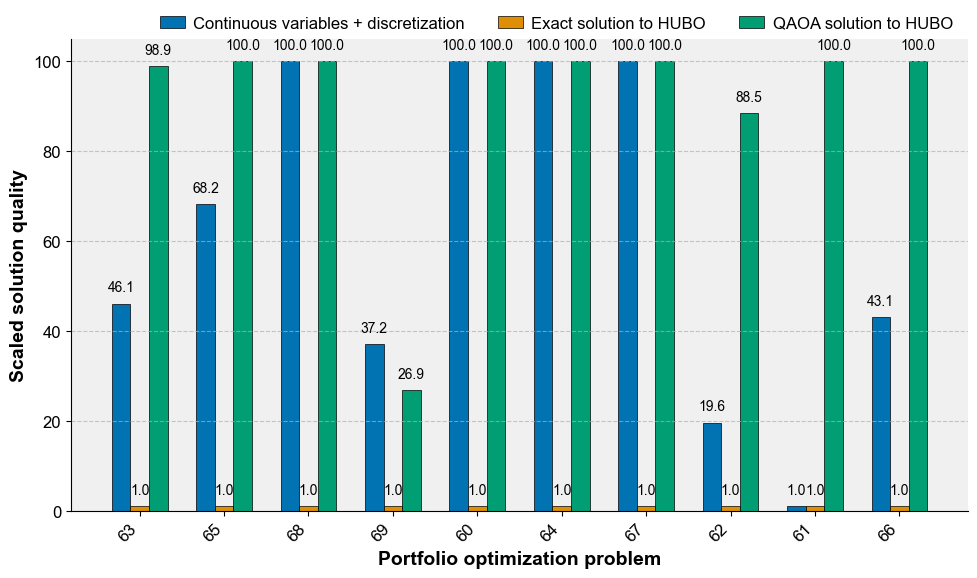

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
max_limit = 100
budget_diff_penalizer = 1

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)
    

def compare_solutions(data):
    results = {}
    
    for case_id, case_data in data.items():
        n_qubits = case_data["hyperparams"]["n_qubits"]
        cont_sol = case_data.get("continuous_variables_solution", {})
        exact_sol = case_data.get("exact_solution", {})
        qaoa_sol = case_data.get("qaoa_solution", {})
        
        cont_value = cont_sol.get("value", 0)
        cont_penalty = budget_diff_penalizer*cont_sol.get("left_overs", 0)
        cont_score = cont_value - cont_penalty

        exact_budgets = exact_sol.get("result_with_budget", [])[0]
        exact_value = exact_budgets.get("objective_value", 0)
        exact_penalty = budget_diff_penalizer*abs(exact_budgets["difference"])
        exact_score = exact_value - exact_penalty

        qaoa_value = qaoa_sol.get("objective_values", [])[-1]
        qaoa_budgets = qaoa_sol.get("result_with_budget", [])[-1]
        qaoa_penalty = budget_diff_penalizer*abs(qaoa_budgets["difference"])
        qaoa_score = qaoa_value - qaoa_penalty

        total_score = cont_score + exact_score + qaoa_score
        #min_score = min(cont_score, exact_score, qaoa_score)
        max_score = max(cont_score, exact_score, qaoa_score)
        cont_normalized = min(cont_score/max_score, max_limit) if cont_score/max_score > 0 else min(1 + 2*np.abs(cont_score/max_score), max_limit)
        exact_normalized = min(exact_score/max_score, max_limit) if exact_score/max_score > 0 else min(1 + 2*np.abs(exact_score/max_score), max_limit)
        qaoa_normalized = min(qaoa_score/max_score, max_limit) if qaoa_score/max_score > 0 else min(1 + 2*np.abs(qaoa_score/max_score), max_limit)

        results[case_id] = {
            "continuous": {"value": cont_value, "penalty": cont_penalty, "score": cont_normalized, "n_qubits": n_qubits},
            "exact": {"value": exact_value, "penalty": exact_penalty, "score": exact_normalized},
            "qaoa": {"value": qaoa_value, "penalty": qaoa_penalty, "score": qaoa_normalized},
        }

        #if case_id == "61":
        #    print(results[case_id])
    
    return results

def plot_scores(results, save_path=None, dpi=300, fig_width=10, fig_height=6):
    """
    Creates a publication-quality bar plot comparing scores across different methods.
    
    Parameters:
    -----------
    results : dict
        Dictionary containing the results for each case and method.
    save_path : str, optional
        Path to save the figure. If None, the figure is displayed but not saved.
    dpi : int, optional
        Resolution of the saved figure in dots per inch.
    fig_width : float, optional
        Width of the figure in inches.
    fig_height : float, optional
        Height of the figure in inches.
    
    Returns:
    --------
    fig, ax : tuple
        Figure and axes objects for further customization if needed.
    """
    
    # Set publication-quality parameters
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'font.size': 14,
        'axes.linewidth': 0.8,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'legend.frameon': False,
        'legend.handlelength': 1.5,
        'legend.handletextpad': 0.5
    })
    
    # Extract data
    cases = list(results.keys())
    continuous_scores = [results[case]["continuous"]["score"] for case in cases]
    exact_scores = [results[case]["exact"]["score"] for case in cases]
    qaoa_scores = [results[case]["qaoa"]["score"] for case in cases]
    n_qubits = [results[case]["continuous"]["n_qubits"] for case in cases][0]
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    # Set smoke gray background for plotting area
    ax.set_facecolor('#f0f0f0')  # Light smoke gray
    
    # Define bar positions
    x = np.arange(len(cases))
    width = 0.22
    
    # Define a professional color palette (colorblind-friendly)
    colors = ['#0173B2', '#DE8F05', '#029E73']
    
    # Plot bars with error bars if available
    cont_bars = ax.bar(x - width, continuous_scores, width, label="Continuous variables + discretization", 
                        color=colors[0], edgecolor='black', linewidth=0.5)
    exact_bars = ax.bar(x, exact_scores, width, label="Exact solution to HUBO", 
                         color=colors[1], edgecolor='black', linewidth=0.5)
    qaoa_bars = ax.bar(x + width, qaoa_scores, width, label="QAOA solution to HUBO", 
                        color=colors[2], edgecolor='black', linewidth=0.5)
    
    # Add value labels on top of bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            if height > 1.05 or height < 100:
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.02*max(continuous_scores + exact_scores + qaoa_scores),
                    f'{height:.1f}', ha='center', va='bottom', fontsize=10)
    
    add_value_labels(cont_bars)
    add_value_labels(exact_bars)
    add_value_labels(qaoa_bars)
    
    # Customize axes
    ax.set_xlabel("Portfolio optimization problem", fontweight='bold')
    ax.set_ylabel("Scaled solution quality", fontweight='bold')
    #ax.set_title(f"Comparison of methods for {n_qubits} qubits", fontweight='bold', fontsize=16)
    
    # Set x-ticks
    ax.set_xticks(x)
    ax.set_xticklabels(cases, rotation=45, ha='right')
    
    # Add grid lines for y-axis only, behind the bars
    ax.yaxis.grid(True, linestyle='--', alpha=0.7, zorder=0)
    
    # Customize spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend in optimal position
    ax.legend(loc='upper right', ncol=3, bbox_to_anchor=(1, 1.08))
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    return fig, ax

def main():
    #file_path = "portfolio_optimization_results.json"  # Update with actual path
    data = {}
    # Get file names like portfolio_optimization_results_batch_ from the parent directory
    files = [file for file in os.listdir("../cmaes_qubo_mean_variance_results/") if "portfolio_optimization_results_batch_" in file]
    for file in files:
        data.update(load_json("../cmaes_qubo_mean_variance_results/" + file))
    
    print(f"Loaded {len(data)} cases.")
    nqubits = 12
    path = f"./{nqubits}_qubits_mean_variance"
    results = compare_solutions(data)
    
    #for case, comparison in results.items():
        #print(f"Case {case}:")
        #for method, values in comparison.items():
        #    print(f"  {method.capitalize()} Solution - Value: {values['value']:.5f}, Penalty: {values['penalty']:.5f}, Score: {values['score']:.5f}")
        #print()
    
    #subset_of_results_qaoa = {}
    #subset_of_results_classical = {}
    subset_of_results = {} #_all = {}
    for key in list(results.keys()):
        n_qubits = results[key]["continuous"]["n_qubits"]
        
        scores = {
        "continuous": results[key]["continuous"]["score"],
        "exact": results[key]["exact"]["score"],
        "qaoa": results[key]["qaoa"]["score"]
        }

        #if key == "61":
        #    print(scores)
        
        # Sort methods based on scores
        sorted_methods = sorted(scores, key=scores.get)

        best_method = sorted_methods[1]

        if n_qubits == nqubits:
            subset_of_results[key] = results[key]
    
    #print(f"Selected {len(subset_of_results_qaoa)} cases with {nqubits} qubits and QAOA as the best method.")
    #print(f"Selected {len(subset_of_results_classical)} cases with {nqubits} qubits and classical as the best method.")
    #plot_scores(subset_of_results_qaoa, save_path = path + "_qaoa")
    #plot_scores(subset_of_results_classical, save_path = path + "_classical")
    plot_scores(subset_of_results, save_path = path)
    return data

data = main()

In [2]:
#file_path = "experiments_data.json"
#data = load_json(file_path)["data"]
#print(json.dumps(data[20], indent=4))


In [3]:
print(json.dumps(data["61"], indent=4))

{
    "hyperparams": {
        "stocks": [
            "AAPL",
            "MMM",
            "UNH"
        ],
        "start": "2015-01-01",
        "end": "2025-01-01",
        "risk_aversion": 0.1,
        "n_qubits": 12,
        "budget": 2754,
        "log_encoding": true,
        "layers": 10,
        "prices_now": {
            "AAPL": 250.1449737548828,
            "MMM": 128.4563446044922,
            "UNH": 503.7073059082031
        },
        "assets_to_qubits": {
            "AAPL": [
                0,
                1,
                2,
                3
            ],
            "MMM": [
                4,
                5,
                6,
                7,
                8
            ],
            "UNH": [
                9,
                10,
                11
            ]
        }
    },
    "continuous_variables_solution": {
        "weights": {
            "AAPL": 1.0000029332048275,
            "MMM": -3.163198824e-06,
            "UNH": 2.305893546e